In [1]:
!pip install kaggle

In [2]:
!pip install pandas numpy scikit-learn pyradiomics matplotlib nibabel

In [3]:
#!mkdir -p ~/.kaggle
#!mv kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

In [4]:
#!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

In [5]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import SimpleITK as sitk
from radiomics import featureextractor
import logging

In [6]:
# set level for all classes
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)
# ... or set level for specific class
logger = logging.getLogger("radiomics.glcm")
logger.setLevel(logging.ERROR)

In [7]:
#TODO: unzip within notebook, remove zip files, rerun notebook

In [8]:
brats_dir = "./BraTS2020" 

Iterate over the downloaded folder to get an idea of the data structure.

In [9]:
# Function to list files in a directory
def explore_directory(path):
    for root, dirs, files in os.walk(path):
        print(f"Directory: {root}")
        for file in files:
            print(f"  {file}")

# Explore datasets
print("Exploring BRATS Dataset:")
explore_directory(brats_dir)


Exploring BRATS Dataset:
Directory: ./BraTS2020
  .DS_Store
Directory: ./BraTS2020/BraTS2020_ValidationData
Directory: ./BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData
  survival_evaluation.csv
  name_mapping_validation_data.csv
Directory: ./BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_069
  BraTS20_Validation_069_flair.nii
  BraTS20_Validation_069_t1.nii
  BraTS20_Validation_069_t2.nii
  BraTS20_Validation_069_t1ce.nii
Directory: ./BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_056
  BraTS20_Validation_056_flair.nii
  BraTS20_Validation_056_t2.nii
  BraTS20_Validation_056_t1.nii
  BraTS20_Validation_056_t1ce.nii
Directory: ./BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_051
  BraTS20_Validation_051_flair.nii
  BraTS20_Validation_051_t2.nii
  BraTS20_Validation_051_t1.nii
  BraTS20_Validation_051_t1ce.nii
Directory: ./BraTS2020/BraTS2020_Validation

In [10]:
path_train = os.path.join(brats_dir, "BraTS2020_TrainingData", "MICCAI_BraTS2020_TrainingData")
path_val = os.path.join(brats_dir, "BraTS2020_ValidationData", "MICCAI_BraTS2020_ValidationData")

print(path_train)
print(path_val)

./BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
./BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData


In [11]:
# Print name mapping, including the labels (Grade column)
map_train = pd.read_csv(os.path.join(path_train, "name_mapping.csv"))
map_val = pd.read_csv(os.path.join(path_val, "name_mapping_validation_data.csv"))
map_train.head()

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005


In [12]:
print(f"Datapoints in Train: {len(map_train)}")
print(f"Labels in Train: {map_train['Grade'].value_counts()}")

Datapoints in Train: 369
Labels in Train: Grade
HGG    293
LGG     76
Name: count, dtype: int64


While the training data set has a csv file with the labels (HGG, LGG fpr high and low grade glioma), the validation data set does not have that column.

In [13]:
map_val.head()

,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,Brats17_CBICA_AAM_1,Brats18_CBICA_AAM_1,NaN,BraTS19_CBICA_AAM_1,BraTS20_Validation_001
1,Brats17_CBICA_ABT_1,Brats18_CBICA_ABT_1,NaN,BraTS19_CBICA_ABT_1,BraTS20_Validation_002
2,Brats17_CBICA_ALA_1,Brats18_CBICA_ALA_1,NaN,BraTS19_CBICA_ALA_1,BraTS20_Validation_003
3,Brats17_CBICA_ALT_1,Brats18_CBICA_ALT_1,NaN,BraTS19_CBICA_ALT_1,BraTS20_Validation_004
4,Brats17_CBICA_ALV_1,Brats18_CBICA_ALV_1,NaN,BraTS19_CBICA_ALV_1,BraTS20_Validation_005


In [14]:
print(f"Datapoints in Val: {len(map_val)}")

Datapoints in Val: 125


In [15]:
# Print survival info
surviv_train = pd.read_csv(os.path.join(path_train, "survival_info.csv"))
surviv_val = pd.read_csv(os.path.join(path_val, "survival_evaluation.csv"))
surviv_train.head()

,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_002,52.263,616,GTR
2,BraTS20_Training_003,54.301,464,GTR
3,BraTS20_Training_004,39.068,788,GTR
4,BraTS20_Training_005,68.493,465,GTR


In [16]:
len(surviv_train)

236

Again we have survival data (in days) for the training set, but the info is not available for the validation set. Also the data seems to be incomplete. 

In [17]:
# Check for missing survival info
missing_survival = map_train[~map_train['BraTS_2020_subject_ID'].isin(surviv_train['Brats20ID'])]
missing_survival

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
129,HGG,Brats17_2013_10_1,Brats18_2013_10_1,NaN,BraTS19_2013_10_1,BraTS20_Training_130
130,HGG,Brats17_2013_5_1,Brats18_2013_5_1,NaN,BraTS19_2013_5_1,BraTS20_Training_131
131,HGG,Brats17_2013_18_1,Brats18_2013_18_1,NaN,BraTS19_2013_18_1,BraTS20_Training_132
132,HGG,Brats17_2013_21_1,Brats18_2013_21_1,NaN,BraTS19_2013_21_1,BraTS20_Training_133
133,HGG,Brats17_2013_19_1,Brats18_2013_19_1,NaN,BraTS19_2013_19_1,BraTS20_Training_134
...,...,...,...,...,...,...
351,HGG,NaN,NaN,NaN,NaN,BraTS20_Training_352
360,HGG,NaN,NaN,NaN,NaN,BraTS20_Training_361
361,HGG,NaN,NaN,NaN,NaN,BraTS20_Training_362
363,HGG,NaN,NaN,NaN,NaN,BraTS20_Training_364


In [18]:
surviv_val.head()

,BraTS20ID,Age,ResectionStatus
0,BraTS20_Validation_001,68.170,GTR
1,BraTS20_Validation_002,50.153,GTR
2,BraTS20_Validation_004,21.726,GTR
3,BraTS20_Validation_006,55.482,GTR
4,BraTS20_Validation_007,64.753,GTR


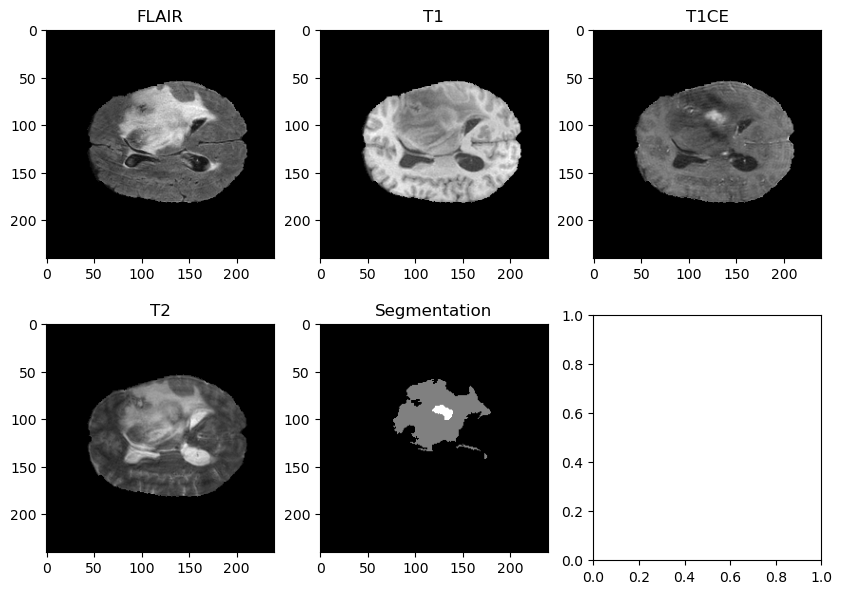

FLAIR Shape: (240, 240, 155)
T1 Shape: (240, 240, 155)
T1CE Shape: (240, 240, 155)
T2 Shape: (240, 240, 155)
Segmentation Shape: (240, 240, 155)
FLAIR Header: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 240 240 155   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern

In [19]:
# Plot all images in one patient

def plot_images(patient_id, path):
    patient_path = os.path.join(path, patient_id)
    flair = nib.load(os.path.join(patient_path, f"{patient_id}_flair.nii")).get_fdata()
    t1 = nib.load(os.path.join(patient_path, f"{patient_id}_t1.nii")).get_fdata()
    t1ce = nib.load(os.path.join(patient_path, f"{patient_id}_t1ce.nii")).get_fdata()
    t2 = nib.load(os.path.join(patient_path, f"{patient_id}_t2.nii")).get_fdata()
    seg = nib.load(os.path.join(patient_path, f"{patient_id}_seg.nii")).get_fdata()
    
    fig, ax = plt.subplots(2, 3, figsize=(10, 7))
    ax[0,0].imshow(flair[..., 80], cmap="gray")
    ax[0,0].set_title("FLAIR")
    ax[0,1].imshow(t1[..., 80], cmap="gray")
    ax[0,1].set_title("T1")
    ax[0,2].imshow(t1ce[..., 80], cmap="gray")
    ax[0,2].set_title("T1CE")
    ax[1,0].imshow(t2[..., 80], cmap="gray")
    ax[1,0].set_title("T2")
    ax[1,1].imshow(seg[..., 80], cmap="gray")
    ax[1,1].set_title("Segmentation")
    plt.show()

    # print metadata
    print(f"FLAIR Shape: {flair.shape}")
    print(f"T1 Shape: {t1.shape}")
    print(f"T1CE Shape: {t1ce.shape}")
    print(f"T2 Shape: {t2.shape}")
    print(f"Segmentation Shape: {seg.shape}")

    # print header
    print(f"FLAIR Header: {nib.load(os.path.join(patient_path, f'{patient_id}_flair.nii')).header}")
    print(f"T1 Header: {nib.load(os.path.join(patient_path, f'{patient_id}_t1.nii')).header}")
    print(f"T1CE Header: {nib.load(os.path.join(patient_path, f'{patient_id}_t1ce.nii')).header}")
    print(f"T2 Header: {nib.load(os.path.join(patient_path, f'{patient_id}_t2.nii')).header}")
    print(f"Segmentation Header: {nib.load(os.path.join(patient_path, f'{patient_id}_seg.nii')).header}")

plot_images("BraTS20_Training_001", path_train)


In [20]:
#TODO: Fix name of segmentation file for id 355